Settings

In [16]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [17]:
%cd /gdrive/My Drive/Challenge2

/gdrive/My Drive/Challenge2


In [18]:
# Import Libraries

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [19]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Data Loading in a *dataframe*

In [20]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


*Training - Test* (0.90/0.1) **split** + **Normalization** (MinMax scaler)

68528
6852
(61676, 7) (6852, 7)


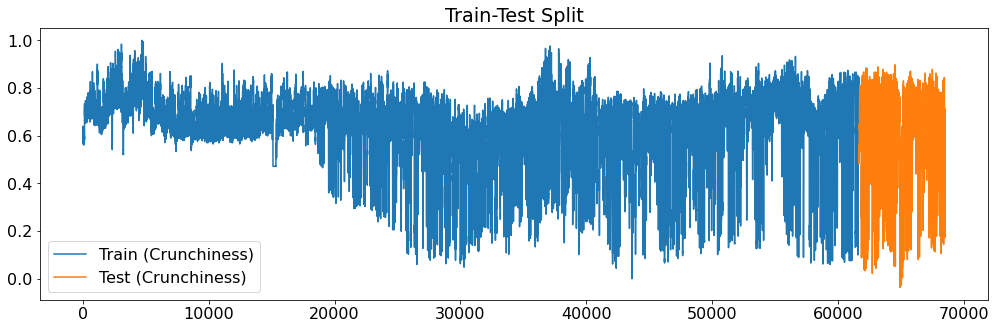

In [21]:
#  We split the given dataset in TRAINING and TEST. Important: Data have not been shuffled before splitting. This is for two reasons:
# 1. It ensures that chopping the data into windows of consecutive samples is still possible.
# 2. It ensures that the training/test results are more realistic, being evaluated on the data collected after the model was trained.

#Split
dataset_len = len(dataset)
print(dataset_len)
split=0.10
test_size=int(dataset_len*split) # validation set size
print(test_size)
X_train_raw = dataset.iloc[0:(dataset_len-test_size)]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

#Maximum and minimum
X_min = X_train_raw.min()
X_max = X_train_raw.max()

#MinMax scaler
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

# Plot of Training and Validation split with normalized data

# Name of the features: 'Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact', 'Meme creativity', 'Soap slipperiness', 'Hype root'

column=2

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.iloc[:,column], label='Train (Crunchiness)')
plt.plot(X_test_raw.iloc[:,column], label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

Parameters for Time Series forecasting with an AutoRegressive model

In [22]:
telescope=9    # How much far away I want to look in the future 
window = 315      # more than the prediction window (864 for the 1st phase)
stride = 21        # chosen such that window/stride has no residual in the division

In [23]:
future = dataset[-window:] # FUTURE is the last window of the dataset
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 315, 7)

Build the sequences (using previous parameters), necessary for training the network

In [24]:
def build_sequences(df, target_labels=dataset.columns, window=window, stride=stride, telescope=telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values # meaningful columns
    padding_len = len(df)%window #only one time since we have only 1 city

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [25]:
target_labels = dataset.columns

In [26]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2925, 315, 7), (2925, 9, 7), (315, 315, 7), (315, 9, 7))

In [27]:
# Model metadata

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 150

Neural network: definition, construction and training

In [28]:
# Attention model

def build_Attention_model(input_shape, output_shape):
    # Build the neural network layer by layer
    
    n_hidden = 64

    input_train = tfkl.Input(shape=(X_train.shape[1], X_train.shape[2]))

    output_train = tfkl.Input(shape=(y_train.shape[1], y_train.shape[2]))

    encoder_stack_h, encoder_last_h, encoder_last_c = tfkl.LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
    
    encoder_last_h = tfkl.BatchNormalization(momentum=0.6)(encoder_last_h)
    encoder_last_c = tfkl.BatchNormalization(momentum=0.6)(encoder_last_c)

    decoder_input = tfkl.RepeatVector(output_train.shape[1])(encoder_last_h)

    decoder_stack_h = tfkl.LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
    return_state=False, return_sequences=True)(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])
    
    attention = tfkl.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = tfkl.Activation('softmax')(attention)

    context = tfkl.dot([attention, encoder_stack_h], axes=[2,1])

    decoder_combined_context = tfkl.concatenate([context, decoder_stack_h])
    
    out = tfkl.TimeDistributed(tfkl.Dense(output_train.shape[2]))(decoder_combined_context)


    model = tfk.Model(inputs=input_train, outputs=out)


    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae']) # idea: create models using different losses!

    # Return the model
    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 315, 7)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 315, 64),    18432       ['input_3[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 64)          256         ['lstm_2[0][1]']                 
 rmalization)                                                                               

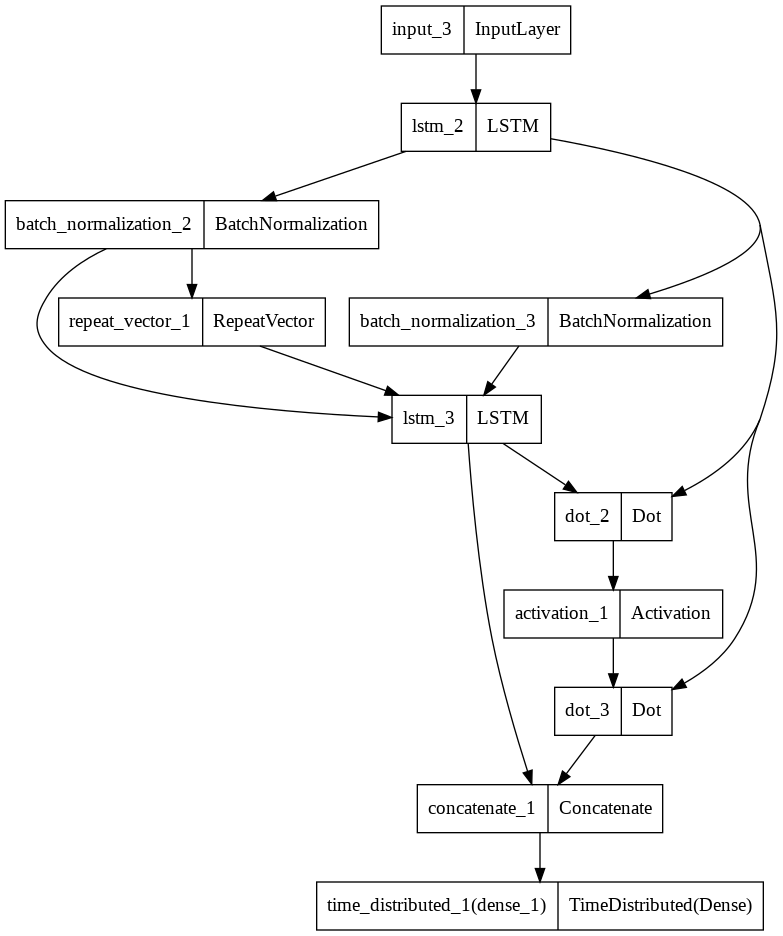

In [29]:
model = build_Attention_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.05, # we split the training in training + validation
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=35, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
# Save the trained model

model.save('Attention_prova1')

In [ ]:
# plots of the training (accuracy on training and validation test)

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Visualize our predictions on the test set

In [ ]:
reg_telescope = 864 #1st phase length
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((122, 300, 7), (122, 864, 7))

In [ ]:
# Autoregressive Forecasting --> forecasting in a for loop
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [ ]:
reg_predictions.shape

(122, 864, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.04354531>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.15481623>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)